In [79]:
import pandas as pd
import numpy as np
import cvxpy as cp
# import mosek
import pickle
from pandas.tseries.offsets import BMonthEnd
from time import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import seaborn as sns

In [162]:
n = 2000

# Get the excess returns data
idx = pd.read_csv('data/TOP{}_universe.csv'.format(n), parse_dates=[0])
idx = idx[idx['date'] >= '1970-01-01'].reset_index(drop = True)

returndata = pd.read_csv('data/crspmsf.csv', index_col = 0)[['date', 'permno', 'ret']]
returndata['date'] = pd.to_datetime( returndata['date'] )
returndata['permno'] = returndata['permno'].astype(int)
returndata = returndata[returndata['date'] >= '1970-01-01'].reset_index(drop = True)
returndata['date'] = pd.to_datetime(returndata['date']) - pd.tseries.offsets.MonthBegin() + pd.tseries.offsets.BMonthEnd()

betaData = pd.read_csv('data/return_pf_excess_ret_beta.csv', index_col = 0)[['date','permno' ,'beta_30']]
betaData['date'] = pd.to_datetime(betaData['date'],format='%Y%m') + BMonthEnd()
betaData = betaData[betaData['date'] >= '1970-01-01'].reset_index(drop = True)

with open('data/exalpha_beta_30.pkl', 'rb') as f:
    data = pickle.load(f)

print(idx.head())
print(data.head())
print(returndata.head())

universe = pd.read_csv(f'data/TOP2000_universe.csv',parse_dates=[0],index_col=0)
universe500 = pd.read_csv(f'data/TOP500_universe.csv',parse_dates=[0],index_col=0)
ff_loadings = pd.read_pickle('data/ffloadings_halflife36_TOP2000.pkl')
ff_cov_df = pd.read_pickle(f'data/ff_cov_halflife{36}.pkl')
spec_est = pd.read_pickle(f'data/spec_est_halflife{36}_TOP{2000}.pkl')

def risk_cov(date):
    ff_cols = ['Mkt-RF','HML','SMB']
    betas = ff_loadings.loc[date,(universe.loc[date],slice(None))].unstack()[ff_cols].dropna(axis=0)
    ff_cov = ff_cov_df.loc[date].loc[ff_cols,ff_cols]
    spec_cov = spec_est.loc[date]
    
    idx = spec_cov.index.intersection(betas.index)
    spec_cov = spec_cov.reindex(idx)
    betas = betas.reindex(idx)

    cov = betas@ff_cov@betas.T + np.diag(spec_cov)
    return cov

        date      0      1      2      3      4      5      6      7      8  \
0 1970-01-30  12490  10401  12079  11754  11850  14322  27983  14736  12060   
1 1970-02-27  12490  10401  12079  11754  11850  14322  14736  27983  12060   
2 1970-03-31  12490  10401  12079  11850  11754  14322  14736  27983  12060   
3 1970-04-30  12490  10401  12079  11850  11754  14322  14736  27983  12060   
4 1970-05-29  12490  10401  12079  11850  11754  14322  14736  27983  12060   

   ...   1990   1991   1992   1993   1994   1995   1996   1997   1998   1999  
0  ...  48661  31480  41304  40256  48573  48899  45460  35246  44177  37444  
1  ...  43174  46711  34331  49998  35051  41304  43406  46519  45823  38340  
2  ...  33582  46500  35641  49429  37612  36644  36695  33830  44943  41574  
3  ...  47618  31106  46498  44804  32459  47407  31819  41574  37989  47685  
4  ...  31595  32440  31106  14197  42876  44513  32133  39132  48848  43537  

[5 rows x 2001 columns]
date        permno
1970-01

In [235]:
def FactorMimickingPortOpt_MV(alpha, beta, gamma, V):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''
    n = V.shape[0]
    x = cp.Variable(n)
    
    obj = cp.Maximize(x.T@alpha - gamma/2*cp.quad_form(x,V))
    constraints = [x.T@beta == 0]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)
    return x.value, prob.value

def FactorMimickingPortOpt_SR(alpha, beta, V, indiv_alpha_contrib=0.1):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''

    # try:

    n = V.shape[0]
    z = cp.Variable(n)
    kappa = cp.Variable(1)

    alpha = alpha.reshape(alpha.shape[0])
    V = cp.atoms.affine.wraps.psd_wrap(V)

    obj = cp.Minimize(cp.quad_form(z,V))

    # ORIGINAL CONSTRAINT: SUM(X)==1 CONSTRAINT IS NOT APPLICABLE
    # constraints = [z.T@beta == 0, z.T@alpha == 1, np.ones(n)@z-kappa==0, kappa>=0, ]
    # FIRST UPDATED CONSTRAINT: WORKS BUT CAN LEAD TO CONCENTRATED PORTFOLIOS
    # constraints = [z.T@beta == 0, z.T@alpha == 1 ]
    # NEW UPDATED CONSTRAINT: LIMIT EACH POSITION'S ALPHA CONTRIBUTION TO A CONSTANT VALUE
    constraints = [z.T@beta == 0, z.T@alpha == 1, cp.multiply(z,alpha) <= indiv_alpha_contrib]
    prob = cp.Problem(obj, constraints)
    val = prob.solve(solver=None,verbose=False)
    if z.value is None:
        raise Exception()
    #return z.value/ kappa.value 
    return z.value


In [243]:
targetVol = 0.4
fullData = dict()
noConv = 0
#for i in range(1, idx['date'].shape[0]):
for i in tqdm(list(range(36,120))):
    start = time()

    #Loop through the dates
    specificDate = idx['date'][i]
    returnsDate = idx['date'][i+1]

    #Get the covariance matrix
    V = risk_cov(specificDate)

    #For that specific date, get the permno of the investable stocks 
    specificPermno = idx[idx['date'] == specificDate].iloc[:, 1:].T
    specificPermno.columns = ['permno']

    #Get the alphas for that specific date
    alphas = pd.DataFrame( data[specificDate]).reset_index()
    alphas['beta_30_exalpha'] = (alphas['beta_30_exalpha'] - alphas['beta_30_exalpha'].mean())/alphas['beta_30_exalpha'].std()

    #Get the betas for that specific date
    betas = betaData[betaData['date'] == specificDate]

    #merge the alphas of that date with the permno of the investable stocks
    alphas_permno = pd.merge(alphas, specificPermno, how = 'inner', on = 'permno')

    #merge the betas of that date with the permno of the investable stocks
    betas_permno = pd.merge(betas, specificPermno, how = 'inner', on = 'permno')

    #Merge the returns of that date with the permno of the investable stocks
    returns_permno = pd.merge(returndata[returndata['date'] == returnsDate].dropna(), specificPermno, how = 'inner', on = 'permno')

    #Merge, alphas, betas and returns 
    investableStocks = pd.merge(alphas_permno, betas_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, returns_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, universe500.loc[specificDate].rename('permno').to_frame(), on = 'permno', how = 'inner')
    investableStocks,V = investableStocks.set_index('permno').align(V,join='inner',axis=0)

    V = V.reindex(columns=V.index)

    # #the shape of investable stocks is not matching with the shape of V.
    # finalPermno = ''
    # if V.shape[0] < investableStocks.shape[0]:
    #     print('V smaller')
    #     finalPermno = list( V.index)
    #     invest_copy = investableStocks.set_index('permno')
    #     investableStocks = invest_copy.loc[finalPermno, :]
    # else:
    #     finalPermno = list( investableStocks.permno)
    #     V = V.loc[finalPermno, finalPermno]

    assert investableStocks.isna().sum().sum() == 0
    assert V.shape[0] == investableStocks.shape[0], 'Shape of alphas and V must match'

    shape = (investableStocks.shape[0], 1)
    alpha = investableStocks['beta_30_exalpha'].values.reshape(shape)
    beta = investableStocks['beta_30'].values.reshape(shape)
    V_np = V.values

    try:
        w = FactorMimickingPortOpt_SR(alpha, beta, V_np)
        portfolioVol = np.sqrt(w.T @ V @ w)
        scaledW = targetVol/portfolioVol * w

        investableStocks['w'] = w
        investableStocks['scaled_w'] = scaledW
    except Exception as e:
        print('No convergence for', specificDate)
        print(e)
        noConv += 1
        investableStocks['w'] = np.nan
        investableStocks['scaled_w'] = np.nan
    
    fullData[specificDate] = investableStocks
    
    end = time()
    finalTime = round( (end - start)/60, 3)

    print('Iteration = {}'.format(i))
    print(finalTime, 'minutes\n')
    
print('No Convergence:', noConv)

  0%|          | 0/84 [00:00<?, ?it/s]

Iteration = 36
0.006 minutes

Iteration = 37
0.006 minutes

Iteration = 38
0.006 minutes

Iteration = 39
0.006 minutes

Iteration = 40
0.006 minutes

Iteration = 41
0.006 minutes

Iteration = 42
0.006 minutes

Iteration = 43
0.006 minutes

Iteration = 44
0.006 minutes

Iteration = 45
0.006 minutes

Iteration = 46
0.006 minutes

Iteration = 47
0.006 minutes

Iteration = 48
0.006 minutes

Iteration = 49
0.006 minutes

Iteration = 50
0.006 minutes

Iteration = 51
0.006 minutes

Iteration = 52
0.006 minutes

Iteration = 53
0.005 minutes

Iteration = 54
0.005 minutes

Iteration = 55
0.005 minutes

Iteration = 56
0.005 minutes

Iteration = 57
0.005 minutes

Iteration = 58
0.005 minutes

Iteration = 59
0.005 minutes

Iteration = 60
0.005 minutes

Iteration = 61
0.005 minutes

Iteration = 62
0.005 minutes

Iteration = 63
0.005 minutes

Iteration = 64
0.005 minutes

Iteration = 65
0.006 minutes

Iteration = 66
0.005 minutes

Iteration = 67
0.005 minutes

Iteration = 68
0.005 minutes

Iteration 

In [244]:
np.sqrt(scaledW.T@V@scaledW)

0.4

In [245]:
investableStocks[investableStocks['beta_30'] <0 ]

,beta_30_exalpha,date_x,beta_30,date_y,ret,w,scaled_w
permno,,,,,,,


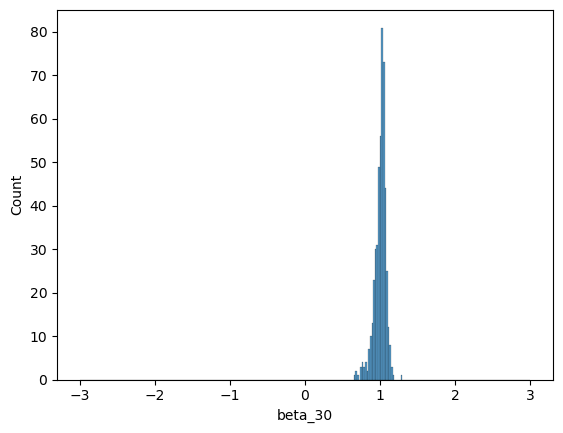

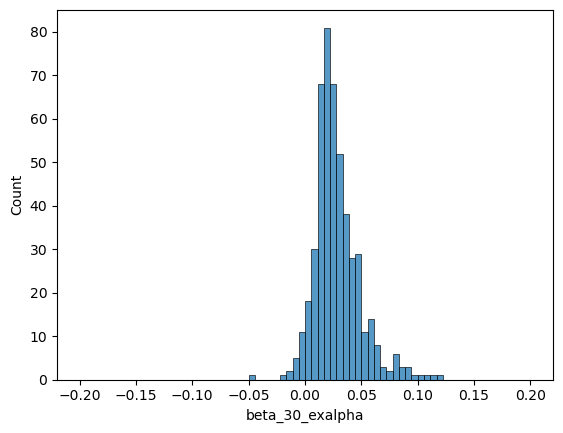

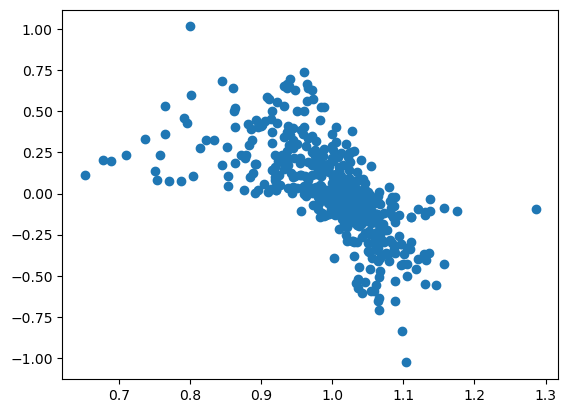

In [248]:
sns.histplot(investableStocks['beta_30'],binrange=(-3,3))
plt.show()
sns.histplot(investableStocks['beta_30_exalpha'],binrange=(-.2,.2))
plt.show()
plt.scatter(investableStocks['beta_30'],investableStocks['scaled_w'])
plt.show()